# Train, Deploy, and Monitor the Music Recommender Model using SageMaker SDK

----

## Background

This notebook is part of a notebook series that goes through the ML lifecycle and shows how we can build a Music Recommender System using a combination of SageMaker services and features. This notebook will train our model using the data we prepped with SageMaker Data Wrangler and stored in our Feature Store, attaching [SageMaker Debugger](https://docs.aws.amazon.com/sagemaker/latest/dg/train-debugger.html) to the model training so that we can capture training metrics/statistics about the model. Then, we will deploy the model and use SageMaker Explainability and Model Monitor to examine our deployed model. After that, we'll log more model artifacts using [SageMaker ML Lineage Tracking](https://docs.aws.amazon.com/sagemaker/latest/dg/lineage-tracking.html). Finally we'll register the model and save its version. It is one of two notebooks you choose to run as the third notebook in the series. You can choose to run this notebook by itself or in sequence with the other notebooks listed below. Please see the [README.md](README.md) for more information about this use case of this sequence of notebooks.

1. [Music Recommender Data Exploration](01_data_exploration.ipynb)
1. [Music Recommender Data Preparation with SageMaker Feature Store and SageMaker Data Wrangler](02_export_feature_groups.ipynb)
1. [Train, Deploy, and Monitor the Music Recommender Model using SageMaker SDK](03_train_deploy_debugger_explain_monitor_registry.ipynb) (current notebook)


<div class="alert alert-info"> 💡 <strong> Alert </strong>

For quicker data processing times, switch to at least an ml.m5.large (General Purpose) notebook instance or larger.
</div>

----
## Contents
1. [Prereqs: Get Data](#Prereqs:-Get-Data)
1. [Train Model](#Train-Model)
1. [Deploy Model](#Deploy-Model)
1. [Create a Predictor](#Create-a-Predictor)
1. [Infer New Songs using Model](#Infer-New-Songs-using-Model)
1. [Explain Model Predictions](#Explain-Model-Predictions)
1. [View SageMaker Debugger Reports](#View-SageMaker-Debugger-Reports)
1. [SageMaker Model Monitor](#SageMaker-Model-Monitor)
1. [Register Model with SageMaker Model Registry](#Register-Model-with-SageMaker-Model-Registry)
1. [Clean Up](#Clean-Up)

In [ ]:
!pip install -qU smdebug
!pip install pandas --upgrade

In [ ]:
import time
import boto3
import argparse
import pandas as pd
import pathlib
import sagemaker
import glob
import json
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
import sys
import pprint

sys.path.insert(1, "./code")

In [ ]:
# SHAP can take some time to install, so we will only install if it doesn't exist already
try:
    import shap
except ModuleNotFoundError:
    !conda install -y -c conda-forge shap

In [ ]:
# SageMaker session
sess = sagemaker.Session()
# get session bucket name
bucket = sess.default_bucket()
# bucket prefix or the subfolder for everything we produce
prefix = "music-recommendation"
# get sagemaker role
sagemaker_role = sagemaker.get_execution_role()
# s3 client
s3_client = boto3.client("s3")

region = boto3.Session().region_name
boto_session = boto3.Session(region_name=region)


sagemaker_client = boto_session.client(service_name="sagemaker", region_name=region)
sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session, sagemaker_client=sagemaker_client
)
featurestore_runtime = boto_session.client(
    service_name="sagemaker-featurestore-runtime", region_name=region
)

feature_store_session = sagemaker.session.Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime,
)

## Prereqs: Get Data 

----

Here we will download the music data from a public S3 bucket that we'll be using for this demo and uploads it to your default S3 bucket that was created for you when you initially created a SageMaker Studio workspace. 

In [ ]:
from demo_helpers import get_data, get_model, update_data_sources

In [ ]:
# create data folder
!mkdir data

In [ ]:
# public S3 bucket that contains our music data
s3_bucket_music_data = "s3://sagemaker-sample-files/datasets/tabular/synthetic-music"

In [ ]:
new_data_paths = get_data(
    s3_client,
    [f"{s3_bucket_music_data}/tracks.csv", f"{s3_bucket_music_data}/ratings.csv"],
    bucket,
    prefix,
    sample_data=0.70,
)
print(new_data_paths)

In [ ]:
files_to_download = [
    f"sample_tracks.csv",
    f"sample_user.csv",
    f"train_data_headers.csv",
    f"train_data.zip",
    f"val_data_headers.csv",
    f"val_data.zip",
]

for file in files_to_download:
    s3_client.download_file(
        f"sagemaker-sample-files", f"datasets/tabular/synthetic-music/{file}", f"./data/{file}"
    )

In [ ]:
! unzip './data/*.zip' -d './data'
! rm ./data/*.zip

In [ ]:
# these are the new file paths located on your SageMaker Studio default s3 storage bucket
tracks_data_source = f"s3://{bucket}/{prefix}/tracks.csv"
ratings_data_source = f"s3://{bucket}/{prefix}/ratings.csv"

### Save data to S3

In [ ]:
%%time

train_headers = pd.read_csv("data/train_data_headers.csv", header=None)[0].tolist()
val_headers = pd.read_csv("data/val_data_headers.csv", header=None)[0].tolist()
train = pd.read_csv("data/train_data.csv", names=train_headers)
val = pd.read_csv("data/val_data.csv", names=val_headers)

s3_client.upload_file("data/train_data.csv", bucket, f"{prefix}/data/train/train_data.csv")
s3_client.upload_file("data/val_data.csv", bucket, f"{prefix}/data/val/val_data.csv")


train_data_uri = f"s3://{bucket}/{prefix}/data/train/train_data.csv"
val_data_uri = f"s3://{bucket}/{prefix}/data/val/val_data.csv"
print(f"Saving training data to {train_data_uri}")

# configure data inputs for SageMaker training
from sagemaker.inputs import TrainingInput

train_input = TrainingInput(train_data_uri, content_type="text/csv")
val_input = TrainingInput(val_data_uri, content_type="text/csv")

## Train Model 

----

In [ ]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig
from sagemaker.estimator import Estimator

In [ ]:
# variables used for parameterizing the notebook run
estimator_output_path = f"s3://{bucket}/{prefix}/training_jobs"
train_instance_count = 2
train_instance_type = "ml.m5.4xlarge"
save_interval = 2
image = sagemaker.image_uris.retrieve("xgboost", region, "0.90-2")
model_name = "music-rec-model-{}".format(datetime.now().strftime("%Y%m%d-%H%M%S"))

hyperparameters = {
    "max_depth": "4",
    "eta": "0.2",
    "objective": "reg:squarederror",
    "num_round": "100",
}

In [ ]:
xgb_estimator = Estimator(
    role=sagemaker_role,
    instance_count=train_instance_count,
    instance_type=train_instance_type,
    image_uri=image,
    hyperparameters=hyperparameters,
    output_path=estimator_output_path,
    debugger_hook_config=DebuggerHookConfig(
        s3_output_path=estimator_output_path + "/debugger",
        collection_configs=[
            CollectionConfig(name="metrics", parameters={"save_interval": str(save_interval)}),
            CollectionConfig(
                name="feature_importance", parameters={"save_interval": str(save_interval)}
            ),
            CollectionConfig(name="full_shap", parameters={"save_interval": str(save_interval)}),
            CollectionConfig(name="average_shap", parameters={"save_interval": str(save_interval)}),
        ],
    ),
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": str(save_interval * 2),
            },
        )
    ],
)

#### Train the model here in order to access SageMaker Debugger
or skip to the next notebook now to deploy a pretrained model

In [ ]:
response = sagemaker_client.list_training_jobs(
    NameContains=model_name, StatusEquals="Completed", SortBy="CreationTime", SortOrder="Descending"
)

In [ ]:
%%time

train_model = True  # True if training a new model, False if wanting to use an existing estimator once you've already trained

if train_model:
    print("Training the model")
    xgb_estimator.fit(inputs={"train": train_input, "validation": val_input}, job_name=model_name)
    s3_debugger_output_path = xgb_estimator.latest_job_debugger_artifacts_path()
elif len(response["TrainingJobSummaries"]) > 0:
    training_job_name = response["TrainingJobSummaries"][0]["TrainingJobName"]
    xgb_estimator = Estimator.attach(training_job_name)
    s3_debugger_output_path = xgb_estimator.latest_job_debugger_artifacts_path()
else:
    print("No existing estimator found. You'll need to run as train = True")

In [ ]:
training_job_name = xgb_estimator.latest_training_job.job_name
print(training_job_name)

In [ ]:
import pprint

training_job_info = sagemaker_client.describe_training_job(TrainingJobName=training_job_name)
pprint.pprint(f"{training_job_info}")

## Deploy Model
----

In [ ]:
endpoint_name = "music-rec-endpoint-{}".format(datetime.now().strftime("%Y%m%d-%H%M%S"))
print(endpoint_name)

In [ ]:
endpoint_list = sagemaker_client.list_endpoints(
    SortBy="CreationTime",
    SortOrder="Descending",
    NameContains=endpoint_name,
    StatusEquals="InService",
)
endpoint_list

### Create endpoint

In [ ]:
%%time
if len(endpoint_list["Endpoints"]) > 0:
    print(f"Using existing endpoint: {endpoint_list['Endpoints'][0]['EndpointName']}")
else:
    # deploy endpoint for model if it doesn't already exist
    xgb_estimator.deploy(
        initial_instance_count=1, instance_type="ml.m4.xlarge", endpoint_name=endpoint_name
    )

## Create a Predictor
----

In [ ]:
predictor = sagemaker.predictor.Predictor(
    endpoint_name=endpoint_name, sagemaker_session=sagemaker_session
)

### Pull user data from feature group

In [ ]:
df_user = pd.read_csv("./data/sample_user.csv")
df_user = df_user.set_index("FeatureName")

### Pull sample of 1000 tracks from feature group

In [ ]:
df_tracks = pd.read_csv("./data/sample_tracks.csv")

In [ ]:
feature_names = pd.read_csv("data/train_data_headers.csv", header=None)[0].tolist()[1:]
data = (
    df_tracks.assign(key=1)
    .merge(pd.DataFrame(df_user["ValueAsString"]).T.assign(key=1), on="key")
    .drop("key", axis=1)
)
data.columns = [c.lower() for c in data.columns]
inference_df = data[feature_names]
inference_df

### Format the datapoint
The datapoint must match the exact input format as the model was trained--with all features in the correct order. In this example, the `col_order` variable was saved when you created the train and test datasets earlier in the guide.

In [ ]:
data_inputs = [",".join([str(i) for i in row]) for row in inference_df.values]

## Infer New Songs using Model
----

In [ ]:
predictions = []
for data_input in data_inputs:
    results = predictor.predict(data_input, initial_args={"ContentType": "text/csv"})
    prediction = json.loads(results)
    predictions.append(prediction)
print(f"Predicted rating for sample user:", prediction)

In [ ]:
# Write to csv in S3 without headers and index column.
inference_df["rating"] = predictions
inference_df = inference_df[["rating"] + feature_names]
inference_df.to_csv("data/prediction_data.csv", header=False, index=False)

s3_client.upload_file("data/prediction_data.csv", bucket, f"{prefix}/data/pred/prediction_data.csv")

pred_data_uri = f"s3://{bucket}/{prefix}/data/pred/prediction_data.csv"

In [ ]:
s3_client.download_file(bucket, f"{prefix}/data/train/train_data.csv", f"train_data.csv")
df_train = pd.read_csv("train_data.csv")

label = "rating"

## Explain Model Predictions
----

In [ ]:
model = xgb_estimator.create_model(name=model_name)
container_def = model.prepare_container_def()
sess.create_model(model_name, sagemaker_role, container_def)

In [ ]:
explainability_output_path = f"s3://{bucket}/{prefix}/clarify-output/explainability"

In [ ]:
clarify_processor = sagemaker.clarify.SageMakerClarifyProcessor(
    role=sagemaker_role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    sagemaker_session=sagemaker_session,
)

model_config = sagemaker.clarify.ModelConfig(
    model_name=model_name, instance_type="ml.m4.xlarge", instance_count=1, accept_type="text/csv"
)

shap_config = sagemaker.clarify.SHAPConfig(
    baseline=[
        df_train.median().values[1:].tolist()
    ],  # ignore the first column since that is that target
    num_samples=100,
    agg_method="mean_abs",
)

explainability_data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=pred_data_uri,
    s3_output_path=explainability_output_path,
    label=label,
    headers=[label] + feature_names,
    dataset_type="text/csv",
)

In [ ]:
%%time
try:
    s3_client.download_file(
        Bucket=bucket,
        Key=f"{prefix}/clarify-output/explainability/explanations_shap/out.csv",
        Filename="data/shap_output.csv",
    )
    print("Downloaded output from previous explainability job")
except Exception as e:
    error = e.response.get("Error").get("Code")
    if error == "404":
        print("Running explainability job")
        clarify_processor.run_explainability(
            data_config=explainability_data_config,
            model_config=model_config,
            explainability_config=shap_config,
        )

In [ ]:
inference_df["trackid"] = data["trackid"]

In [ ]:
playlist_length = 10  # number of songs to recommend in playlist
playlist = inference_df.sort_values(by="rating", ascending=False).head(playlist_length)
print("Curated Playlist:\n", playlist["trackid"])

In [ ]:
s3_client.download_file(
    bucket, f"{prefix}/clarify-output/explainability/explanations_shap/out.csv", f"out.csv"
)
local_explanations_out = pd.read_csv("out.csv")
local_explanations_out.columns = feature_names

print("Model prediction:", playlist.iloc[0, 0])
plt.figure(figsize=(12, 6))
local_explanations_out.iloc[0].sort_values().plot.barh(title="Local explanation for prediction")

## View SageMaker Debugger Reports

----

A machine learning training job can have problems such as system bottlenecks, overfitting, saturated activation functions, and vanishing gradients, which can compromise model performance. SageMaker Debugger profiles and debugs training jobs to help resolve such problems and improve your ML model's compute resource utilization and performance. Debugger offers tools to send alerts when training anomalies are found, take actions against the problems, and identify the root cause of them by visualizing collected metrics and tensors.. 


### Create the Trail for the Experiment uisng the Debugger to generate trial debug-output

See this explanation for more information : https://github.com/awslabs/sagemaker-debugger/blob/master/docs/analysis.md

In [ ]:
%%time
from smdebug.trials import create_trial

try:
    trial = create_trial(s3_debugger_output_path)
except:
    parameters = ps.read("music-rec")
    s3_debugger_output_path = parameters["s3_debugger_output_path"]
    trial = create_trial(s3_debugger_output_path)

In [ ]:
feature_names = list(train.drop("rating", axis=1).columns)
print(feature_names)

In [ ]:
from itertools import islice
import matplotlib.pyplot as plt
import re

MAX_PLOTS = 35


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals


def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1] == "f{}".format(str(ifeat)):
            return feature_name
    return tensor_name


def plot_collection(trial, collection_name, regex=".*", figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = trial.collection(collection_name).tensor_names
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Iteration")

In [ ]:
plot_collection(trial, "metrics")

In [ ]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(trial, "feature_importance", regex=f"feature_importance/{importance_type}/.*")

In [ ]:
plot_feature_importance(trial, importance_type="gain")

### SHAP

[SHAP](https://github.com/slundberg/shap) (SHapley Additive exPlanations) is another approach to explain the output of machine learning models.
SHAP values represent a feature's contribution to a change in the model output. You instructed Estimator to log the average SHAP values in this example so the SHAP values (as calculated by [xgboost.predict(pred_contribs=True)](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.predict)) will be available the `average_shap` collection.
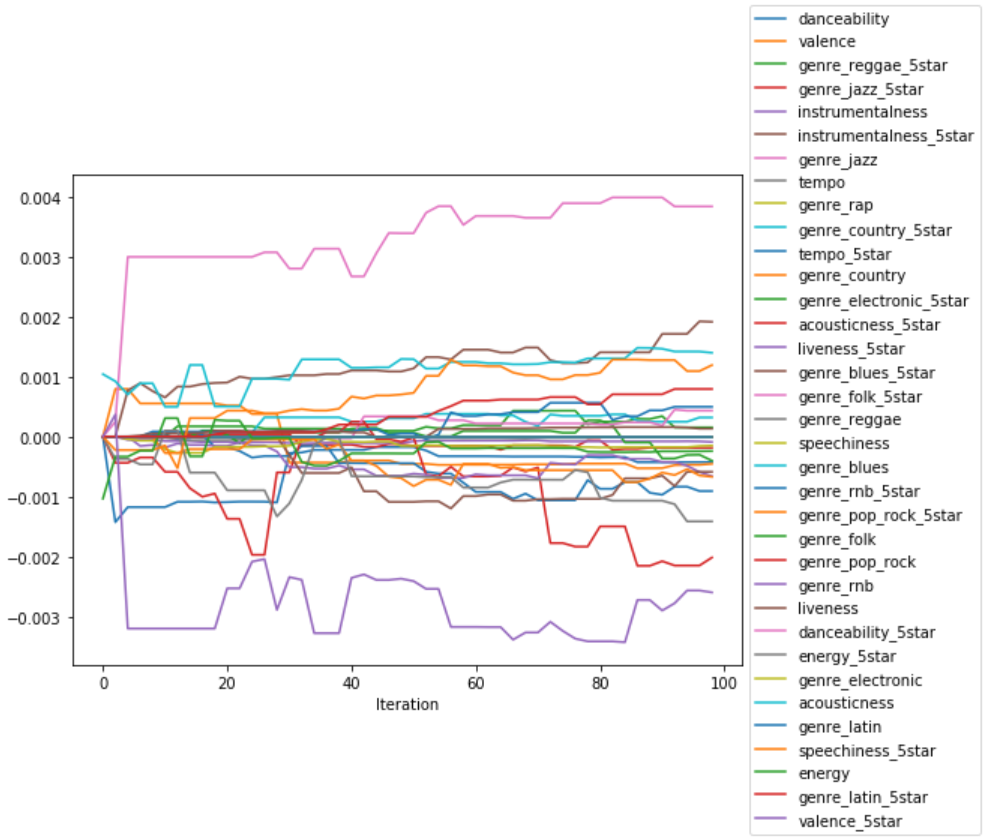

In [ ]:
plot_collection(trial, "average_shap")

### Global explanations

Global explanatory methods allow understanding the model and its feature contributions in aggregate over multiple datapoints. Here we show an aggregate bar plot that plots the mean absolute SHAP value for each feature. 
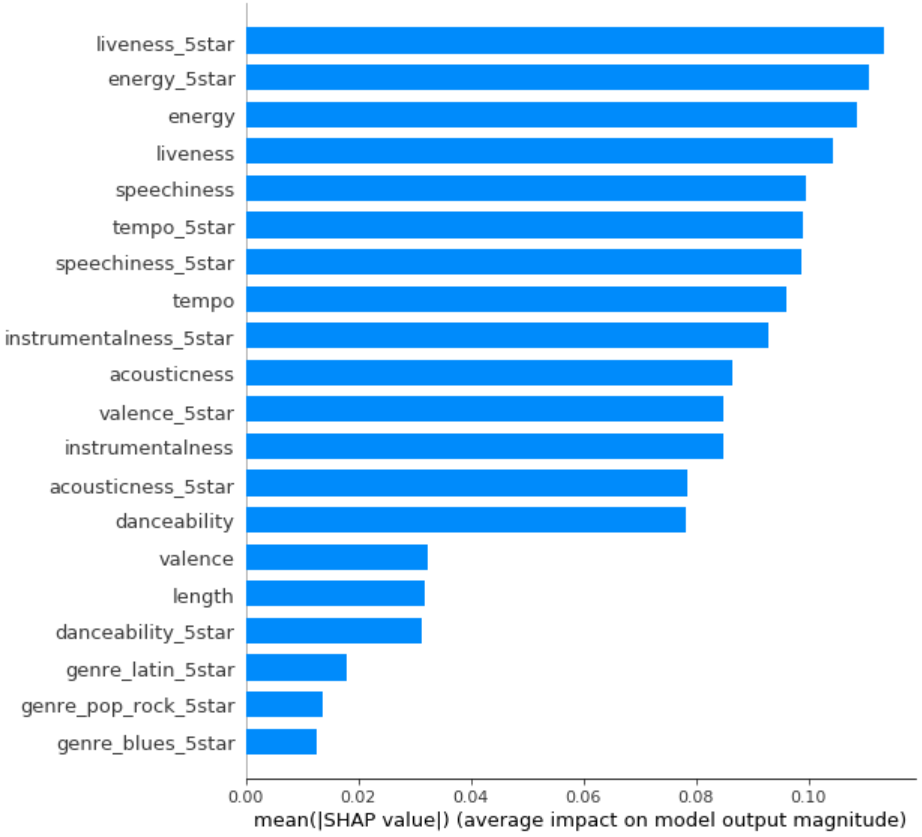

In [ ]:
import shap

shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type="bar", feature_names=feature_names)

In [ ]:
shap_base_value

The detailed summary plot below can provide more context over the above bar chart. It tells which features are most important and, in addition, their range of effects over the dataset. The color allows us to match how changes in the value of a feature effect the change in prediction. 

The 'red' indicates higher value of the feature and 'blue' indicates lower (normalized over the features).

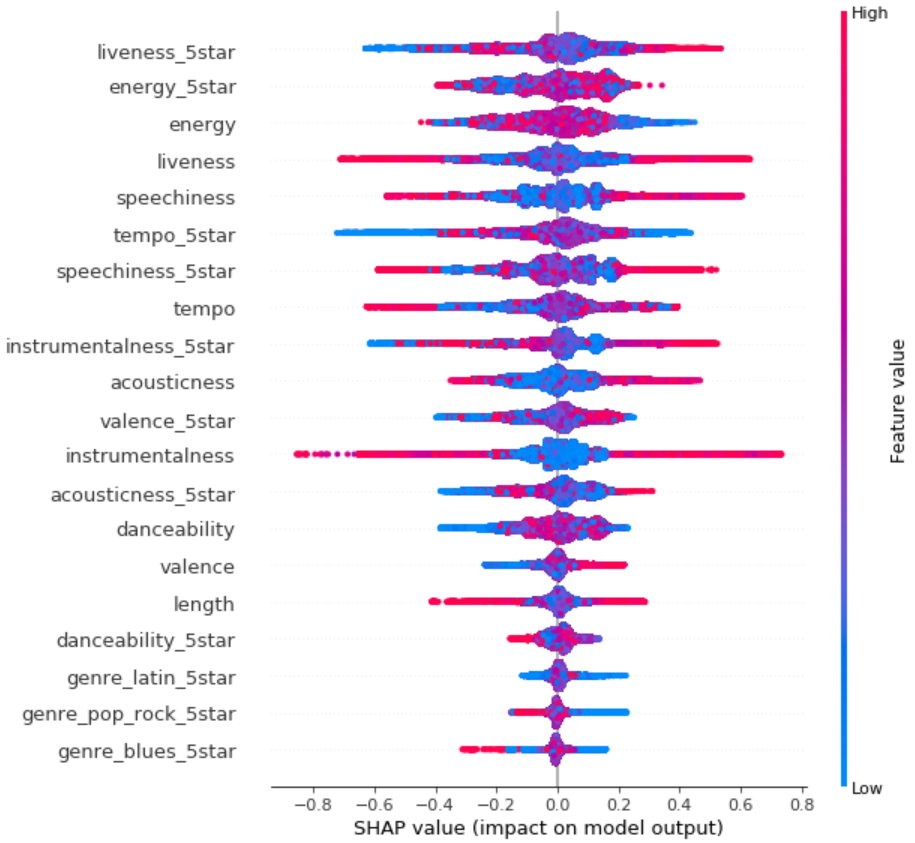

In [ ]:
X_train = train.iloc[:, 1:]
shap.summary_plot(shap_no_base, X_train)

## SageMaker Model Monitor

### Step 1: Enable real-time inference data capture
----

To enable data capture for monitoring the model data quality, you specify the new capture option called `DataCaptureConfig`. You can capture the request payload, the response payload or both with this configuration. The capture config applies to all variants. Please provide the Endpoint name in the following cell:

In [ ]:
from sagemaker.model_monitor import DataCaptureConfig

# Please fill in the following for enabling data capture
s3_capture_upload_path = f"s3://{bucket}/{prefix}/endpoint-data-capture/"  # example: s3://bucket-name/path/to/endpoint-data-capture/

#####
## IMPORTANT
##
## Please make sure to add the "s3:PutObject" permission to the "role' you provided in the SageMaker Model
## behind this Endpoint. Otherwise, Endpoint data capture will not work.
##
#####

In [ ]:
%%time
# Change parameters as you would like - adjust sampling percentage,
#  chose to capture request or response or both
data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=25,
    destination_s3_uri=s3_capture_upload_path,
    kms_key_id=None,
    capture_options=["REQUEST", "RESPONSE"],
    csv_content_types=["text/csv"],
    json_content_types=["application/json"],
)

# Now it is time to apply the new configuration and wait for it to be applied
predictor.update_data_capture_config(data_capture_config=data_capture_config)
sess.wait_for_endpoint(endpoint=endpoint_name)

#### Before you proceed:
Currently SageMaker supports monitoring Endpoints out of the box only for **tabular (csv, flat-json)** datasets. If your Endpoint uses some other datasets, these following steps will NOT work for you.


### Step 2: Model Monitor - Baselining
----

In addition to collecting the data, SageMaker allows you to monitor and evaluate the data observed by the Endpoints. For this :
1. We need to create a baseline with which we compare the realtime traffic against. 
1. Once a baseline is ready, we can setup a schedule to continously evaluate/compare against the baseline.

#### Constraint suggestion with baseline/training dataset

The training dataset with which you trained the model is usually a good baseline dataset. Note that the training dataset's data schema and the inference dataset schema should exactly match (i.e. number and order of the features).

Using our training dataset, we'll ask SageMaker to suggest a set of baseline constraints and generate descriptive statistics to explore the data.

In [ ]:
##'s3://bucketname/path/to/baseline/data' - Where your validation data is
baseline_data_uri = val_data_uri
##'s3://bucketname/path/to/baseline/data' - Where the results are to be stored in
baseline_results_uri = f"s3://{bucket}/{prefix}/baseline/results"

print("Baseline data uri: {}".format(baseline_data_uri))
print("Baseline results uri: {}".format(baseline_results_uri))

#### Create a baselining job with the validation dataset

Now that we have the training data ready in S3, let's kick off a job to `suggest` constraints. `DefaultModelMonitor.suggest_baseline(..)` kicks off a `ProcessingJob` using a SageMaker provided Model Monitor container to generate the constraints. Please edit the configurations to fit your needs.

In [ ]:
from sagemaker.model_monitor import DefaultModelMonitor
from sagemaker.model_monitor.dataset_format import DatasetFormat
from sagemaker import get_execution_role
import datetime

role = get_execution_role(sagemaker_session=sess)

datetime_stamp = datetime.datetime.now().strftime("%Y-%m-%d-%H%M%S")

my_default_monitor = DefaultModelMonitor(
    role=role,
    instance_count=2,
    instance_type="ml.m5.xlarge",
    volume_size_in_gb=20,
    max_runtime_in_seconds=1800,
    base_job_name=f"{prefix}-monitor-{datetime_stamp}",
)

In [ ]:
%%time

monitor_baseline = my_default_monitor.suggest_baseline(
    baseline_dataset=baseline_data_uri,
    dataset_format=DatasetFormat.csv(header=False),
    output_s3_uri=baseline_results_uri,
    job_name=f"{prefix}-monitor-baseline-{datetime_stamp}",
    wait=True,
)

#### Exploratory Analysis of the Processing Jobs underlying SageMaker Monitor
In this short section [next few cells] we will be showing you how to further view the underlying jobs for the monitoring job

In [ ]:
from time import gmtime, strftime
import boto3

client = boto3.client("sagemaker")


def get_last_processing_job():

    response = client.list_processing_jobs(
        NameContains=f"{prefix}-monitor-baseline-{datetime_stamp}",
        StatusEquals="Completed",
        SortBy="CreationTime",
        SortOrder="Descending",
        MaxResults=20,
    )
    pprint.pprint(response["ProcessingJobSummaries"][0])
    return response["ProcessingJobSummaries"][0]["ProcessingJobName"]

In [ ]:
from sagemaker.processing import ProcessingJob
from sagemaker.estimator import Estimator
from sagemaker.model_monitor.model_monitoring import ModelMonitor

my_default_monitor_name = get_last_processing_job()

In [ ]:
my_default_monitor_reload = ProcessingJob.from_processing_name(sess, my_default_monitor_name)

response = client.describe_processing_job(ProcessingJobName=my_default_monitor_name)
pprint.pprint(response)

#### Explore the generated constraints and statistics

In [ ]:
import pandas as pd

baseline_job = my_default_monitor.latest_baselining_job
schema_df = pd.io.json.json_normalize(baseline_job.baseline_statistics().body_dict["features"])
schema_df.head(10)

In [ ]:
constraints_df = pd.io.json.json_normalize(
    baseline_job.suggested_constraints().body_dict["features"]
)
constraints_df.head(10)

Before proceeding to enable monitoring, you could chose to edit the constraint file as required to fine tune the constraints.

### Step 3: Enable continous monitoring
----

We have collected the data above, here we proceed to analyze and monitor the data with MonitoringSchedules.

#### Create a schedule

We are ready to create a model monitoring schedule for the Endpoint created earlier with the baseline resources (constraints and statistics).

In [ ]:
from sagemaker.model_monitor import CronExpressionGenerator
import datetime as datetime
from time import gmtime, strftime


mon_schedule_name = "music-rec-monitor-schedule-{}".format(
    datetime.datetime.now().strftime("%Y-%m-%d-%H%M%S")
)
s3_report_path = f"s3://{bucket}/{prefix}/monitor/report"

try:
    my_default_monitor.create_monitoring_schedule(
        monitor_schedule_name=mon_schedule_name,
        endpoint_input=endpoint_name,
        output_s3_uri=s3_report_path,
        statistics=my_default_monitor.baseline_statistics(),
        constraints=my_default_monitor.suggested_constraints(),
        schedule_cron_expression=CronExpressionGenerator.daily(),
        enable_cloudwatch_metrics=True,
    )
    print(f"Created monitoring schedule {mon_schedule_name}")
except:
    my_default_monitor.update_monitoring_schedule(
        endpoint_input=endpoint_name,
        schedule_cron_expression=CronExpressionGenerator.daily(),
        enable_cloudwatch_metrics=True,
    )
    print(f"Updated monitoring schedule {my_default_monitor.monitoring_schedule_name}")

In [ ]:
import time

desc_schedule_result = my_default_monitor.describe_schedule()
while desc_schedule_result["MonitoringScheduleStatus"] != "Scheduled":
    print("Schedule status: {}".format(desc_schedule_result["MonitoringScheduleStatus"]))
    desc_schedule_result = my_default_monitor.describe_schedule()
    time.sleep(30)
print("Schedule status: {}".format(desc_schedule_result["MonitoringScheduleStatus"]))

#### All set
Now that your monitoring schedule has been created. Please return to the Amazon SageMaker Studio to list the executions for this Schedule and observe the results going forward.

## Register Model with SageMaker Model Registry

Amazon SageMaker ML Lineage Tracking creates and stores information about the steps of a machine learning workflow from data preparation to model deployment. With the tracking information you can reproduce the workflow steps, track model and dataset lineage, and establish model governance and audit standards

----

In [ ]:
mpg_name = prefix + "-notebooks"

model_packages = sagemaker_client.list_model_packages(ModelPackageGroupName=mpg_name)[
    "ModelPackageSummaryList"
]

if model_packages:
    print(f"Using existing Model Package Group: {mpg_name}")
else:
    mpg_input_dict = {
        "ModelPackageGroupName": mpg_name,
        "ModelPackageGroupDescription": "Music Recommendation Models",
    }

    mpg_response = sagemaker_client.create_model_package_group(**mpg_input_dict)
    print(f"Create Model Package Group {mpg_name}: SUCCESSFUL")

In [ ]:
sys.path.insert(1, "./code")
from inference_specification import InferenceSpecification

model_uri = training_job_info.get("ModelArtifacts", {}).get("S3ModelArtifacts")
training_image = training_job_info["AlgorithmSpecification"]["TrainingImage"]

mp_inference_spec = InferenceSpecification().get_inference_specification_dict(
    ecr_image=training_image,
    supports_gpu=False,
    supported_content_types=["text/csv"],
    supported_mime_types=["text/csv"],
)

mp_inference_spec["InferenceSpecification"]["Containers"][0]["ModelDataUrl"] = model_uri
mp_input_dict = {
    "ModelPackageGroupName": mpg_name,
    "ModelPackageDescription": "SageMaker Music Recommender",
    "ModelApprovalStatus": "PendingManualApproval",
}

mp_input_dict.update(mp_inference_spec)
mp_response = sagemaker_client.create_model_package(**mp_input_dict)

model_packages = sagemaker_client.list_model_packages(ModelPackageGroupName=mpg_name)[
    "ModelPackageSummaryList"
]
model_packages

### Create Model from Estimator

In [ ]:
model_matches = sagemaker_client.list_models(NameContains=model_name)["Models"]

for model_name_match in model_matches:
    sagemaker_session.delete_model(model_name_match["ModelName"])
    print(f"Deleted existing model: {model_name_match['ModelName']}")

model = sagemaker_session.create_model_from_job(
    name=model_name,
    training_job_name=training_job_name,
    role=sagemaker_role,
    image_uri=training_job_info["AlgorithmSpecification"]["TrainingImage"],
)

print(f"Created new model: {model_name}")

## Clean Up
----

In [ ]:
import demo_helpers  # our custom set of functions

demo_helpers.delete_project_resources(
    sagemaker_boto_client=sagemaker_client,
    sagemaker_session=sagemaker_session,
    endpoint_names=[endpoint_name],
    mpg_name=mpg_name,
    prefix=prefix,
    delete_s3_objects=True,
    bucket_name=bucket,
)